
<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
    <td style="background-color:transparent;"><a href="http://www.datascience-paris-saclay.fr">
<img border="0" src="http://project.inria.fr/saclaycds/files/2017/02/logoUPSayPlusCDS_990.png" width="90%"> </td>
<img border="0" src="http://www.auchylesmines.fr/wp-content/uploads/2015/03/Logo-securite-routiere-651x263.jpg" width="60%"> </td>
  </tr>
</table> 
</div>

<center><h1>France accident challenge</h1></center>
<br/>
<center>Nayel Bettache (ENSAE), Axel Marchand (ENSAE), Solène Cochennec (HEC-ENSAE), Rodrigue Rillardon (ENSAE)</center>

Predicting accidents using Open Data Gouv Data: [Open Data Gouv](https://www.data.gouv.fr/fr/)

## Table of Contents

0. [Introduction](#Introduction)
1. [Data](#Data)
3. [Score metric](#Score-metric)
4. [Data exploration](#Data-exploration)
5. [Predictions](#Predictions)
6. [Record linkage](#Record-linkage)
7. [Submission structure](#Submission-structure)
8. [Local testing](#Local-testing-(before-submission))
9. [Submitting to RAMP studio](#Submitting-to-[ramp.studio](http://ramp.studio))
10. [More information](#More-information)

# Introduction

The objective of this challenge is to work with 'massive' and 'raw' data. We have a really high number of datasets, with most of the data either useless or at first not explained or use. Most real data is dirty and the availability of high-quality, open-source ML and data analysis frameworks (such as [scikit-learn](https://scikit-learn.org/),
[pandas](https://pandas.pydata.org/)...) means that the next frontier for tooling and automation lies in preprocessing. This challenge aims to investigate methodologies to perform statistical analysis directly on the original dirty data.

We have at our disposal about 14 years of data about the road accidents in France from 2004 to 2018. We will only use 3 years to avoid using a dataset too huge. 

There are twelve datasets in this challenge, describing the years 2018, 2017, 2016. Each year has 4 differents datasets

* `caracteristiques_{YEAR}.csv` - basic data about the accidents.
* `lieux_{YEAR}.csv` - data about the location of the accidents.
* `usagers_{YEAR}.csv` - data about the people involved in the accidents.
* `vehicules_{YEAR}.csv` - data about the vehicles involved.


# Aim

The predictive aim of this challenge is to use the different datasets to predict the number of accidents for each location in a day. It is advised that you use all datasets, as it improves the prediction (see [Score comparison](#Score-comparison)), but using only the `caracteristiques_{YEAR}.csv` dataset is also allowed.

In [ ]:
!python download_data.py

=> File saved as data/vehicules_2018.csv
=> File saved as data/usagers_2018.csv
=> File saved as data/lieux_2018.csv
=> File saved as data/caracteristiques_2018.csv
=> File saved as data/vehicules_2017.csv
=> File saved as data/usagers_2017.csv
=> File saved as data/lieux_2017.csv


# Data


### Get the data 

In [2]:
import pandas as pd
import os
from data_cleaning import preparation_data 


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
path = "./data/" 

## Concatenation des bases des différents années si concat=True 
df_caracteristiques, df_lieux, df_usagers, df_vehicules = preparation_data(path,concat=True)


/Users/rodriguerillardon/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3249: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Inside Preparation_data : 
- Si option concat (préférable) : 4 tables regroupant les années 2016, 2017 et 2018 chacune 
- Suppression des doublon dans la base caracteristiques
- Transformation des variablles an, mois et jour 
- Création des variables Date, heure et jour_semaine 

# Les différents quartiers de Paris

On va se limiter uniquement aux quartiers administratifs de Paris

In [5]:
data_quartier = pd.read_csv(f"{path}quartier_paris.csv", sep=";")
data_quartier.head()

,N_SQ_QU,C_QU,C_QUINSEE,L_QU,C_AR,N_SQ_AR,PERIMETRE,SURFACE,Geometry X Y,Geometry
0,750000017,17,7510501,Saint-Victor,5,750000005,3087.215040,6.041561e+05,"48.8476636355,2.35409315338","{""type"": ""Polygon"", ""coordinates"": [[[2.354921..."
1,750000031,31,7510803,Madeleine,8,750000008,3791.509735,7.607266e+05,"48.871265493,2.32005302865","{""type"": ""Polygon"", ""coordinates"": [[[2.325031..."
2,750000078,78,7512002,Saint-Fargeau,20,750000020,5405.036433,1.486971e+06,"48.8710347391,2.40617153015","{""type"": ""Polygon"", ""coordinates"": [[[2.413813..."
3,750000063,63,7511603,Porte-Dauphine,16,750000016,7447.041546,3.086718e+06,"48.8717656343,2.27191774047","{""type"": ""Polygon"", ""coordinates"": [[[2.270984..."
4,750000069,69,7511801,Grandes-Carrières,18,750000018,6398.474434,1.905566e+06,"48.8925777711,2.33436308991","{""type"": ""Polygon"", ""coordinates"": [[[2.340216..."


In [6]:
import folium

paris_map = folium.Map(location=[48.83, 2.34], 
                       control_scale=True, 
                       zoom_start=12)

folium.Choropleth(geo_data=f"{path}quartier_paris.geojson", 
                     highlight=True, name='Quartier de Paris').add_to(paris_map)
paris_map

# Ajouter les capteurs du traffic

Nous disposons de 3000 capteurs de traffics que nous allons disposer sur la carte

In [11]:
data_capteurs = pd.read_csv(f"{path}referentiel-comptages-routiers.csv",
                            sep=';')
data_capteurs.head()

,IU_AC,DATE_DEBUT,DATE_FIN,LIBELLE,IU_ND_AVAL,IU_ND_AMONT,LIBELLE_ND_AMONT,LIBELLE_ND_AVAL,geo_point_2d,geo_shape,SHAPE.LEN
0,5444,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Auteuil,2859,2465,SE_Auteuil,AE_A13,"48.8480073438,2.25343813301","{""type"": ""LineString"", ""coordinates"": [[2.2523...",0.0
1,5184,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Point_du_Jour,2504,2725,SE_VGP,AE_Lafont,"48.8354710712,2.2583742872","{""type"": ""LineString"", ""coordinates"": [[2.2569...",0.0
2,5446,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Parc_Princes,2489,2462,AE_Auteuil,SE_St_Cloud,"48.8430097717,2.25407136126","{""type"": ""LineString"", ""coordinates"": [[2.2548...",0.0
3,5169,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Pont_aval,604,2504,AE_Lafont,SE_Quai_Issy,"48.8348752621,2.26318604615","{""type"": ""LineString"", ""coordinates"": [[2.2598...",0.0
4,5214,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PI_Quai_Issy,598,595,SI_Quai_Issy,AI_Quai_Issy,"48.8352960423,2.26978165613","{""type"": ""LineString"", ""coordinates"": [[2.2719...",0.0


In [12]:
data_capteurs['geo_point_2d']=[i.split(',') for i in data_capteurs['geo_point_2d']]

In [13]:
capteurs_map = folium.Map(location=[48.83, 2.34], 
                       control_scale=True, 
                       zoom_start=12)

for index, row in data_capteurs.iloc[:200,:].iterrows():
    folium.Marker(row["geo_point_2d"], 
                  popup=row["LIBELLE"]).add_to(capteurs_map)
capteurs_map

Nous n'avons représenté ici que 300 capteurs de trafic à Paris, il y en a en réalité près de 4000. Ces 4000 capteurs envoient chaque heure l'état du trafic. Soit sur une année $4000\times24\times365>35\times 10^6$ lignes à traiter. Nous avons donc décider de garder uniquement 300 capteurs.

## Savoir si situer un accident et un capteur

Il est indispensable de pouvoir déterminer si un accident est intervenu dans Paris et, deuxièmement, le numéro de quartier administratif de ce dernier.

In [14]:
import json
from shapely.geometry import shape, Point

def open_geojson_get_shapes(file):
    with open(file) as f:
        js=json.load(f)
    return js['features']

all_geo_shape = open_geojson_get_shapes(f"{path}quartier_paris.geojson")

def check_which_quartier(lon,lat,list_quartier=all_geo_shape, printing=False):
    point = Point(lat, lon)
    nb_quartier = None
    for quartier in list_quartier:
        polygon = shape(quartier['geometry'])
        if polygon.contains(point):
            nb_quartier = quartier["properties"]["c_qu"]
            if printing:
                print(f"Found in tiequar {quartier['properties']['l_qu']}")
    return nb_quartier
                  
    

In [15]:
l = check_which_quartier(48.83, 2.34, printing=True)
print(l)

Found in tiequar Parc-de-Montsouris
54


In [16]:
for index, row in data_capteurs.iterrows():
    lat, long = float(row["geo_point_2d"][0]),float(row["geo_point_2d"][1])
    data_capteurs["Num_Qu"]=check_which_quartier(lat, long)
data_capteurs.head()

,IU_AC,DATE_DEBUT,DATE_FIN,LIBELLE,IU_ND_AVAL,IU_ND_AMONT,LIBELLE_ND_AMONT,LIBELLE_ND_AVAL,geo_point_2d,geo_shape,SHAPE.LEN,Num_Qu
0,5444,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Auteuil,2859,2465,SE_Auteuil,AE_A13,"[48.8480073438, 2.25343813301]","{""type"": ""LineString"", ""coordinates"": [[2.2523...",0.0,80
1,5184,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Point_du_Jour,2504,2725,SE_VGP,AE_Lafont,"[48.8354710712, 2.2583742872]","{""type"": ""LineString"", ""coordinates"": [[2.2569...",0.0,80
2,5446,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Parc_Princes,2489,2462,AE_Auteuil,SE_St_Cloud,"[48.8430097717, 2.25407136126]","{""type"": ""LineString"", ""coordinates"": [[2.2548...",0.0,80
3,5169,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Pont_aval,604,2504,AE_Lafont,SE_Quai_Issy,"[48.8348752621, 2.26318604615]","{""type"": ""LineString"", ""coordinates"": [[2.2598...",0.0,80
4,5214,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PI_Quai_Issy,598,595,SI_Quai_Issy,AI_Quai_Issy,"[48.8352960423, 2.26978165613]","{""type"": ""LineString"", ""coordinates"": [[2.2719...",0.0,80


## Restriction des données à Paris

On va maintenant restreindre notre dataframe d'accidents aux seuls accidents parisiens.

In [17]:
df_caracteristiques.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,Date,jour_semaine,heure
0,201800000001,2018,01,24,1505,1,1,4,1.0,1.0,5,route des Ansereuilles,M,50.55737,2.94992,590,2018-01-24 15:05:00,2,15
1,201800000002,2018,02,12,1015,1,2,7,7.0,7.0,11,Place du général de Gaul,M,50.52936,2.93151,590,2018-02-12 10:15:00,0,10
2,201800000003,2018,03,04,1135,1,2,3,1.0,7.0,477,Rue nationale,M,50.51243,2.91714,590,2018-03-04 11:35:00,6,11
3,201800000004,2018,05,05,1735,1,2,1,7.0,3.0,52,30 rue Jules Guesde,M,50.51974,2.89123,590,2018-05-05 17:35:00,5,17
4,201800000005,2018,06,26,1605,1,2,1,1.0,3.0,477,72 rue Victor Hugo,M,50.51607,2.90605,590,2018-06-26 16:05:00,1,16


In [18]:
df_caracteristiques.shape

(118484, 19)

In [19]:
from tqdm.auto import tqdm

tqdm.pandas(desc="my bar!")
df_caracteristiques['Num_Qu'] = df_caracteristiques.progress_apply(lambda x: check_which_quartier(x.lat, x.long), axis=1)
df_caracteristiques.head()
    

/Users/rodriguerillardon/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,Date,jour_semaine,heure,Num_Qu
0,201800000001,2018,01,24,1505,1,1,4,1.0,1.0,5,route des Ansereuilles,M,50.55737,2.94992,590,2018-01-24 15:05:00,2,15,NaN
1,201800000002,2018,02,12,1015,1,2,7,7.0,7.0,11,Place du général de Gaul,M,50.52936,2.93151,590,2018-02-12 10:15:00,0,10,NaN
2,201800000003,2018,03,04,1135,1,2,3,1.0,7.0,477,Rue nationale,M,50.51243,2.91714,590,2018-03-04 11:35:00,6,11,NaN
3,201800000004,2018,05,05,1735,1,2,1,7.0,3.0,52,30 rue Jules Guesde,M,50.51974,2.89123,590,2018-05-05 17:35:00,5,17,NaN
4,201800000005,2018,06,26,1605,1,2,1,1.0,3.0,477,72 rue Victor Hugo,M,50.51607,2.90605,590,2018-06-26 16:05:00,1,16,NaN


In [20]:
df_paris_accident = df_caracteristiques[df_caracteristiques["Num_Qu"]>=0]

In [21]:
df_paris_accident.shape

(10956, 20)

In [22]:
df_paris_accident.head()

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,Date,jour_semaine,heure,Num_Qu
5632,201800005633,2018,04,06,0015,5,2,1,1.0,5.0,88,QUINZIEME CORPS (AV. DU),M,48.86000,2.28000,60,2018-04-06 00:15:00,4,0,62.0
5669,201800005670,2018,05,20,1620,1,2,2,1.0,3.0,88,GARIGLIANO (PONTS),M,48.86272,2.28759,60,2018-05-20 16:20:00,6,16,64.0
20248,201800020249,2018,07,23,1531,1,2,3,7.0,6.0,33,RENAN (AVENUE ERNEST),M,48.86272,2.28759,180,2018-07-23 15:31:00,0,15,64.0
26701,201800026702,2018,11,22,1300,1,1,1,2.0,6.0,4,RD 2007,M,48.86272,2.28759,450,2018-11-22 13:00:00,3,13,64.0
28285,201800028286,2018,01,05,1755,5,1,2,3.0,6.0,395,DOMBASLE (PLACE),M,48.83550,2.30037,540,2018-01-05 17:55:00,4,17,57.0


Nous avons nos 11000 accidents

### Import des données de temperature

In [9]:
df_temperature = pd.read_csv('./data/meteo_jour.csv')

In [10]:
df_temperature.head()

,jour,temp_high,temp_avg,temp_low,dew_point_high,dew_point_avg,dew_point_low,humidity_high,humidity_avg,humidity_low,speed_high,speed_avg,speed_low,pressure_high,pressure_low,precipitation_acc
0,1/01/2016,49.4,46.3,44.1,44.1,42.5,40.9,91.0,87.0,80.0,10.0,4.0,0.0,30.27,29.82,NaN
1,2/01/2016,52.6,49.6,46.7,46.3,44.3,40.9,89.0,82.0,74.0,11.0,6.1,3.0,29.82,29.74,NaN
2,3/01/2016,48.7,46.4,44.2,45.3,42.2,39.4,91.0,85.0,75.0,11.0,6.4,2.0,29.84,29.22,NaN
3,4/01/2016,51.9,47.4,44.9,44.3,42.1,40.5,86.0,82.0,73.0,8.0,4.9,2.0,29.30,29.23,NaN
4,5/01/2016,50.0,46.6,44.1,43.4,41.8,39.8,89.0,83.0,75.0,9.0,5.3,3.0,29.37,29.24,NaN


Cette base nous donne des informations sur des données météorologique par jour entre 2016 et 2018.

# Base de train:

On va dans un premier temps faire une base de train avec l'heure et le numéro de quartier.

In [91]:
import datetime
pd.date_range(datetime.datetime(year=2016, month=1, day=1, hour=1),
              datetime.datetime(year=2018, month=12, day=31, hour=23),
              freq="1h")


DatetimeIndex(['2016-01-01 01:00:00', '2016-01-01 02:00:00',
               '2016-01-01 03:00:00', '2016-01-01 04:00:00',
               '2016-01-01 05:00:00', '2016-01-01 06:00:00',
               '2016-01-01 07:00:00', '2016-01-01 08:00:00',
               '2016-01-01 09:00:00', '2016-01-01 10:00:00',
               ...
               '2018-12-31 14:00:00', '2018-12-31 15:00:00',
               '2018-12-31 16:00:00', '2018-12-31 17:00:00',
               '2018-12-31 18:00:00', '2018-12-31 19:00:00',
               '2018-12-31 20:00:00', '2018-12-31 21:00:00',
               '2018-12-31 22:00:00', '2018-12-31 23:00:00'],
              dtype='datetime64[ns]', length=26303, freq='H')

In [23]:
26303*80

2104240


## Caracteristiques



$\textbf{List of features}:\\ $   
- Num_Acc : Accident number 
- An : année 
- Mois : Mois
- Jour : Jour 
- hrmn : heure et minutes
- lum : qualité de l'éclairage 
- agg : localisation ( 1: hors agglomération, 2: agglomération) 
- int : intersection 
- atm : conditions atmosphériques
- col : type de collision 
- com : commune (numéro donné par l'INSEE)  
- adr : adresse 
- gps : M (Métropoles), A (Antilles), G (Guyane), R (Réunion), Y (Mayotte)
- lat : latitude 
- long : longitude 
- dep : départmenet (code INSEE)

Beaucoup de duplicate, suppprimés dans preparation_data

In [57]:
df_caracteristiques.head(15)

,Num_Acc,an,mois,jour,hrmn,lum,agg,int,atm,col,com,adr,gps,lat,long,dep,Date,jour_semaine,heure
0,201800000001,2018,01,24,1505,1,1,4,1.0,1.0,5,route des Ansereuilles,M,50.55737,2.94992,590,2018-01-24 15:05:00,2,15
1,201800000002,2018,02,12,1015,1,2,7,7.0,7.0,11,Place du général de Gaul,M,50.52936,2.93151,590,2018-02-12 10:15:00,0,10
2,201800000003,2018,03,04,1135,1,2,3,1.0,7.0,477,Rue nationale,M,50.51243,2.91714,590,2018-03-04 11:35:00,6,11
3,201800000004,2018,05,05,1735,1,2,1,7.0,3.0,52,30 rue Jules Guesde,M,50.51974,2.89123,590,2018-05-05 17:35:00,5,17
4,201800000005,2018,06,26,1605,1,2,1,1.0,3.0,477,72 rue Victor Hugo,M,50.51607,2.90605,590,2018-06-26 16:05:00,1,16
5,201800000006,2018,09,23,0630,2,2,1,2.0,6.0,52,D39,M,50.52132,2.88837,590,2018-09-23 06:30:00,6,6
6,201800000007,2018,09,26,0040,5,2,1,1.0,6.0,133,4 route de camphin,M,50.52211,2.96652,590,2018-09-26 00:40:00,2,0
7,201800000008,2018,11,30,1715,5,2,1,1.0,6.0,11,rue saint exupéry,M,50.53146,2.93875,590,2018-11-30 17:15:00,4,17
8,201800000009,2018,02,18,1557,1,1,1,1.0,6.0,550,rue de l'égalité,M,50.53707,2.84896,590,2018-02-18 15:57:00,6,15
9,201800000010,2018,03,19,1530,1,2,2,1.0,1.0,51,face au 59 rue de Lille,M,50.53639,2.81517,590,2018-03-19 15:30:00,0,15


## On se limite uniquement à Paris

In [74]:
mask = ((df_caracteristiques["lat"]<=48.90) & (df_caracteristiques["long"]<=2.42)
       & (48.82<=df_caracteristiques["lat"]) & (2.26<=df_caracteristiques["long"]))

df_caracteristiques = df_caracteristiques[mask]


In [75]:
df_caracteristiques.heure

5632       0
5669      16
20248     15
26701     13
28285     17
          ..
116389    17
116390    18
116392     6
116393     8
116395    20
Name: heure, Length: 10692, dtype: int64

In [76]:
df_caracteristiques.dtypes

Num_Acc                  int64
an                      object
mois                    object
jour                    object
hrmn                    object
lum                      int64
agg                      int64
int                      int64
atm                    float64
col                    float64
com                      int64
adr                     object
gps                     object
lat                    float64
long                   float64
dep                      int64
Date            datetime64[ns]
jour_semaine             int64
heure                    int64
dtype: object

In [77]:
df_caracteristiques.isna().sum()

Num_Acc         0
an              0
mois            0
jour            0
hrmn            0
lum             0
agg             0
int             0
atm             0
col             0
com             0
adr             0
gps             0
lat             0
long            0
dep             0
Date            0
jour_semaine    0
heure           0
dtype: int64

In [78]:
df_caracteristiques.nunique()

Num_Acc         10692
an                  2
mois               12
jour               31
hrmn              910
lum                 5
agg                 2
int                 9
atm                 9
col                 7
com                79
adr              6481
gps                 1
lat              2179
long             5667
dep                17
Date            10330
jour_semaine        7
heure              24
dtype: int64

### Accidents en fonction des données temporelles

Somme des accidents en fonction du mois 

In [79]:
df_caracteristiques.mois.value_counts().sort_index()

01     813
02     735
03     938
04     980
05     974
06    1093
07     872
08     596
09     933
10    1034
11     906
12     818
Name: mois, dtype: int64

Somme des accidents en fonction du jour de la semaine (0:lundi ...) 

In [80]:
df_caracteristiques.jour_semaine.value_counts().sort_index()

0    1549
1    1651
2    1627
3    1656
4    1773
5    1355
6    1081
Name: jour_semaine, dtype: int64

Somme des accidents en fonction de l'heure

In [81]:
df_caracteristiques.heure.value_counts().sort_index()

0     278
1     188
2     168
3     137
4      88
5     118
6     159
7     262
8     568
9     671
10    508
11    527
12    570
13    644
14    620
15    618
16    636
17    755
18    778
19    747
20    576
21    407
22    330
23    339
Name: heure, dtype: int64

In [82]:
table = df_caracteristiques.pivot_table('Num_Acc', 'heure', 'jour_semaine', aggfunc="count")
table

jour_semaine,0,1,2,3,4,5,6
heure,,,,,,,
0,32.0,34.0,25.0,33.0,48.0,62.0,44.0
1,7.0,23.0,24.0,17.0,34.0,35.0,48.0
2,11.0,14.0,6.0,20.0,28.0,41.0,48.0
3,10.0,6.0,12.0,25.0,18.0,25.0,41.0
4,6.0,NaN,9.0,2.0,17.0,26.0,28.0
5,9.0,9.0,10.0,7.0,19.0,32.0,32.0
6,24.0,20.0,19.0,15.0,18.0,31.0,32.0
7,54.0,42.0,48.0,35.0,42.0,18.0,23.0
8,99.0,118.0,109.0,107.0,99.0,27.0,9.0


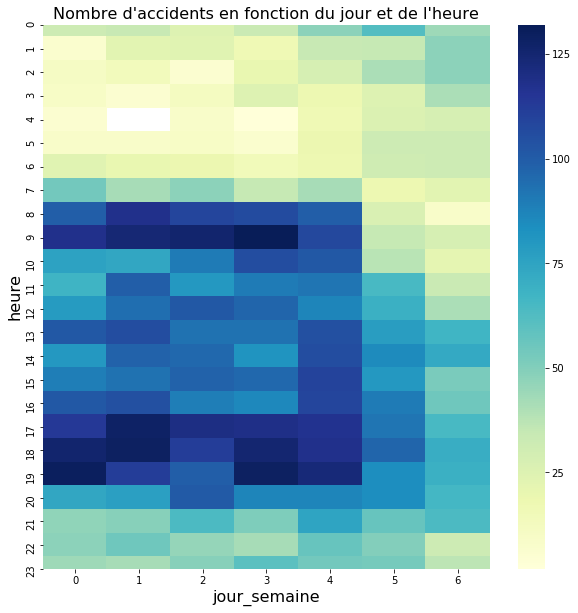

In [83]:
plt.figure(figsize=(10, 10))
plt.title('Nombre d\'accidents en fonction du jour et de l\'heure', fontsize=16)
plt.xlabel('', fontsize=16)
plt.ylabel('', fontsize=16)

heatmap = sns.heatmap(table, cmap="YlGnBu")

### Représentation des accidents en France en 2018

In [84]:
import folium
from folium.plugins import HeatMap

In [85]:
df_map = df_caracteristiques.dropna(subset=['lat','long'])
df_map = df_map[df_map.an=='2018']
df_map['count'] = 1

In [86]:
df_map.shape

(5024, 20)

In [87]:
def generateBaseMap(default_location=[48.82, 2.34], default_zoom_start=12):
    base_map = folium.Map(location=default_location, control_scale=True, zoom_start=default_zoom_start)
    return base_map

In [110]:
base_map = generateBaseMap()
HeatMap(data=df_map[['lat', 'long', 'count']].groupby(['lat', 'long']).sum().reset_index().values.tolist(), radius=8, max_zoom=13).add_to(base_map)
base_map

### Représentation des accidents en 2018 en fonction de l'heure de la journée 

In [89]:
from folium.plugins import HeatMapWithTime

In [90]:
df_map_list = []

for heure in df_map.heure.sort_values().unique():
    df_map_list.append(df_map.loc[df_map.heure == heure, ['lat', 'long', 'count']].groupby(['lat', 'long']).sum().reset_index().values.tolist()) 
    
df_heure_list = df_map.heure.sort_values().unique().tolist()


In [91]:
base_map = generateBaseMap(default_zoom_start=11)

HeatMapWithTime(data=df_map_list, index = df_heure_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

### Représentation des accidents en 2018 en fonction du jour de la semaine 

In [25]:
df_map_jour_list = []

for jour in df_map.jour_semaine.sort_values().unique():
    df_map_jour_list.append(df_map.loc[df_map.jour_semaine == jour, ['lat', 'long', 'count']].groupby(['lat', 'long']).sum().reset_index().values.tolist()) 
    
df_jour_list = df_map.jour_semaine.sort_values().unique().tolist()


In [26]:
base_map = generateBaseMap(default_zoom_start=11)

HeatMapWithTime(data=df_map_jour_list, index = df_jour_list, radius=5, gradient={0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}, min_opacity=0.5, max_opacity=0.8, use_local_extrema=True).add_to(base_map)
base_map

# Nous nous limitons à Paris

## Lieux



$\textbf{List of features}: \\ $ 
- Num_Acc : numéro accident 
- catr: Catégorie de route 
- voie : numéro de route 
- V1 : indice numérique du numéro de route (2 bis etc.) 
- V2 : lettre indice alphanumérique de la route 
- circ: régime de circulation (sens unique...) 
- nbv: nombre total de voies de circulation  
- vosp : signal l'existence de voie réservée (pidte cyclable...) 
- prof : pente de la route (1: plat..) 
- pr : numéro du PR de rattrachement (borne amont) 
- pr1 : distance en mètres au PR 
- plan : tracé en plan (courbe ou ligne droite...) 
- lartpc : largeur du terre plein central si existant 
- larrout : largueur de la chaussée affectée à la circulation des véhicules 
- surf : état de la surface (normale, mouillée...) 
- infra : infrastructure (pont, tunnel) 
- situ : situation de l'accident (chaussée, trottoir...) 
- env1 : indicatrice proximité d'une école 

In [27]:
df_lieux.head(5)

,Num_Acc,catr,voie,v1,v2,circ,nbv,pr,pr1,vosp,prof,plan,lartpc,larrout,surf,infra,situ,env1
0,201800000001,3,41,NaN,C,2.0,2.0,NaN,NaN,0.0,1.0,3.0,NaN,NaN,1.0,0.0,1.0,0.0
1,201800000002,4,41,NaN,D,2.0,2.0,NaN,NaN,0.0,1.0,2.0,NaN,NaN,1.0,0.0,1.0,0.0
2,201800000003,3,39,NaN,D,2.0,2.0,NaN,NaN,0.0,1.0,1.0,NaN,NaN,1.0,0.0,1.0,0.0
3,201800000004,3,39,NaN,NaN,2.0,2.0,NaN,NaN,0.0,1.0,1.0,NaN,NaN,1.0,0.0,1.0,0.0
4,201800000005,4,NaN,NaN,NaN,1.0,1.0,NaN,NaN,0.0,1.0,1.0,NaN,NaN,1.0,0.0,1.0,0.0


In [28]:
df_lieux.shape 

(177916, 18)

In [29]:
df_lieux.nunique()

Num_Acc    177916
catr            8
voie         1861
v1              2
v2             52
circ            5
nbv            14
pr            569
pr1          1492
vosp            4
prof            5
plan            5
lartpc        263
larrout       418
surf           10
infra           8
situ            6
env1            3
dtype: int64

## Usagers



$\textbf{List of features}: \\ $ 
- Num_Acc : numéro accident, NON unique, puisque même numéro pour chaque usager de l'accident 
- place: place dans le véhicule au moment de l'accident (1: conducteur) 
- catu : catégorie d'usager (conducteur, passager, piéton ...) 
- grav : gravité de l'accident (1: indemne, 2: Tué, 3: Blessé hospitalisé et 4: Blessé léger) 
- sexe : 1 (Masculin), 2 (Féminin) 
- trajet : motif du déplacement (domicile-travail etc )  
- sécu : équipement de sécurité et unitilisation de l'équipement (11 = 1: ceinture + 1: Oui )
- locp: localisation du piéton 
- actp : action du piéton 
- étatp : piéton seul ou non 
- an_nais : année de naissance de l'usager
- num_veh : identifiant du véhicule 

In [30]:
df_usagers.head(15)

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh
0,201800000001,1.0,1,3,1,0.0,11.0,0.0,0.0,0.0,1928.0,B01
1,201800000001,1.0,1,1,1,5.0,11.0,0.0,0.0,0.0,1960.0,A01
2,201800000002,1.0,1,1,1,0.0,11.0,0.0,0.0,0.0,1947.0,A01
3,201800000002,NaN,3,4,1,0.0,2.0,2.0,3.0,1.0,1959.0,A01
4,201800000003,1.0,1,3,1,5.0,21.0,0.0,0.0,0.0,1987.0,A01
5,201800000003,1.0,1,1,1,0.0,3.0,0.0,0.0,0.0,1977.0,C01
6,201800000004,1.0,1,3,1,5.0,2.0,0.0,0.0,0.0,2013.0,B01
7,201800000004,1.0,1,1,1,5.0,11.0,0.0,0.0,0.0,1982.0,A01
8,201800000005,1.0,1,4,1,5.0,21.0,0.0,0.0,0.0,2001.0,A01
9,201800000005,1.0,1,1,1,5.0,11.0,0.0,0.0,0.0,1946.0,B01


In [31]:
df_usagers.shape

(399612, 12)

In [32]:
df_usagers.nunique()

Num_Acc    177916
place           9
catu            4
grav            4
sexe            2
trajet          7
secu           18
locp            9
actp            8
etatp           4
an_nais       106
num_veh        86
dtype: int64

## Vehicles


$\textbf{List of features}: \\ $ 
- Num_Acc : numéro accident, NON unique, puisque même numéro pour chaque véhicule de l'accident 
- senc : sens de circulation 
- catv : catégorie du véhicule 
- occutc : nombre d'occupants dans le transport en commun 
- obs : obstacle fixe heurté (type) 
- obsm : obstacle mobile heurté 
- choc : point de choc initiale (1: avant, 2: avant droit...) 
- manv : manoeuvre principale avant l'accident (1: sans chgt de direction, 4: en marche arrière...) 
- num_veh : identifiant du véhicule (repris dans la base usager)

In [33]:
df_vehicules.head(15)

,Num_Acc,senc,catv,occutc,obs,obsm,choc,manv,num_veh
0,201800000001,0.0,7,0,0.0,2.0,3.0,1.0,B01
1,201800000001,0.0,7,0,0.0,2.0,2.0,15.0,A01
2,201800000002,0.0,7,0,0.0,1.0,0.0,1.0,A01
3,201800000003,0.0,33,0,1.0,2.0,1.0,1.0,A01
4,201800000003,0.0,7,0,0.0,2.0,8.0,15.0,B01
5,201800000003,0.0,7,0,0.0,0.0,7.0,24.0,C01
6,201800000004,0.0,1,0,0.0,2.0,8.0,0.0,B01
7,201800000004,0.0,7,0,0.0,9.0,2.0,21.0,A01
8,201800000005,0.0,2,0,0.0,2.0,2.0,17.0,A01
9,201800000005,0.0,7,0,0.0,2.0,3.0,20.0,B01


In [34]:
df_vehicules.nunique()

Num_Acc    177916
senc            3
catv           24
occutc         92
obs            17
obsm            7
choc           10
manv           25
num_veh        87
dtype: int64

In [35]:
df_vehicules.isna().sum()

Num_Acc      0
senc       272
catv         0
occutc       0
obs        282
obsm       227
choc       179
manv       169
num_veh      0
dtype: int64

# Traffic

In [92]:
import os

In [93]:
list_all_dir_traffic = os.listdir("/Users/amarchand/Downloads/opendata_txt_2017/")

In [98]:
df_traffic = pd.read_csv("/Users/amarchand/Downloads/opendata_txt_2017/trafic_capteurs_2017_W03_20170119_20170126.txt"
                        , sep=';')

In [108]:
df_traffic.h

,iu_ac,libelle,iu_nd_amont,libelle_nd_amont,iu_nd_aval,libelle_nd_aval,t_1h,q,k,etat_trafic,etat_barre,dessin
0,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2017-01-19 01:00:00,87.0,0.38944,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
1,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2017-01-19 02:00:00,47.0,0.22500,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
2,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2017-01-19 03:00:00,34.0,0.13500,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
3,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2017-01-19 04:00:00,19.0,0.05945,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
4,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2017-01-19 05:00:00,24.0,0.09834,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
5,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2017-01-19 06:00:00,56.0,0.15889,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
6,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2017-01-19 07:00:00,167.0,0.39111,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
7,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2017-01-19 08:00:00,529.0,1.82111,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
8,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2017-01-19 09:00:00,649.0,7.45222,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."
9,799,Bd_Kellermann,460,Bd_Kellermann-Moulin_Pointe,459,Bd_Kellermann-Damesme,2017-01-19 10:00:00,688.0,6.53889,1,3,"""<PLINE COURBE=""""1""""><PT X=""""601352"""" Y=""""1245..."


In [106]:
df_all_iu = pd.read_csv("/Users/amarchand/Downloads/referentiel-comptages-routiers.csv", sep=";",error_bad_lines=False)
df_all_iu.head()

,IU_AC,DATE_DEBUT,DATE_FIN,LIBELLE,IU_ND_AVAL,IU_ND_AMONT,LIBELLE_ND_AMONT,LIBELLE_ND_AVAL,geo_point_2d,geo_shape,SHAPE.LEN
0,5444,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Auteuil,2859,2465,SE_Auteuil,AE_A13,"48.8480073438,2.25343813301","{""type"": ""LineString"", ""coordinates"": [[2.2523...",0.0
1,5184,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Point_du_Jour,2504,2725,SE_VGP,AE_Lafont,"48.8354710712,2.2583742872","{""type"": ""LineString"", ""coordinates"": [[2.2569...",0.0
2,5446,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Parc_Princes,2489,2462,AE_Auteuil,SE_St_Cloud,"48.8430097717,2.25407136126","{""type"": ""LineString"", ""coordinates"": [[2.2548...",0.0
3,5169,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PE_Pont_aval,604,2504,AE_Lafont,SE_Quai_Issy,"48.8348752621,2.26318604615","{""type"": ""LineString"", ""coordinates"": [[2.2598...",0.0
4,5214,2005-01-01T02:00:00+01:00,2019-06-01T04:00:00+02:00,PI_Quai_Issy,598,595,SI_Quai_Issy,AI_Quai_Issy,"48.8352960423,2.26978165613","{""type"": ""LineString"", ""coordinates"": [[2.2719...",0.0



## Training and test

# Merge the databases 

In [1]:
df_merge = pd.merge(df_caracteristiques, df_lieux, left_on="Num_Acc", right_on="Num_Acc")  
df_merge

NameError: name 'pd' is not defined

# Score metric

# Data exploration

## Caracteristiques

## Lieux

## Usagers

TEST